# Выбор локации для скважины

Нужно решить, где бурить новую скважину.

Предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски.

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [651]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings('ignore')

In [652]:
geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')
geo_data_0.info()
geo_data_0.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [653]:
geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')
geo_data_1.info()
geo_data_1.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [654]:
geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')
geo_data_2.info()
geo_data_2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


В данных отсутствуют пропуски

In [655]:
#Удаляю из всех датафреймов столбцы id, они не являются значимыми для модели.
geo_data_0 = geo_data_0.drop(['id'], axis=1)
geo_data_1 = geo_data_1.drop(['id'], axis=1)
geo_data_2 = geo_data_2.drop(['id'], axis=1)

In [656]:
#Количество нулевых значений
def zeroes_check(geo_data, product):
    zeros = geo_data[geo_data[product] == 0][product].count()
    percent = zeros / geo_data.shape[0]
    print('Количество нулевых значений -', zeros)
    print('Процент нулевых значений -', percent)

In [657]:
zeroes_check(geo_data_0, 'product')

Количество нулевых значений - 1
Процент нулевых значений - 1e-05


In [658]:
zeroes_check(geo_data_1, 'product')

Количество нулевых значений - 8235
Процент нулевых значений - 0.08235


In [659]:
zeroes_check(geo_data_2, 'product')

Количество нулевых значений - 1
Процент нулевых значений - 1e-05


In [660]:
def zeroes_show(geo_data, product):
    print(geo_data[geo_data[product] == 0])

In [661]:
zeroes_show(geo_data_0, 'product')

             f0        f1        f2  product
57263 -0.702064  0.375992  0.236572      0.0


In [662]:
zeroes_show(geo_data_1, 'product')

              f0         f1        f2  product
11     16.320755  -0.562946 -0.001783      0.0
13      6.695604  -0.749449 -0.007630      0.0
62     21.418478  -5.134490 -0.002836      0.0
63      6.822701   3.104979 -0.000723      0.0
77      6.750150 -11.893512 -0.001601      0.0
...          ...        ...       ...      ...
99936   5.085749  -3.980305  0.005063      0.0
99948   8.277805  -9.178818  0.003275      0.0
99956  13.343983  -1.290200  0.005980      0.0
99961  13.854163 -11.528089 -0.005556      0.0
99973  12.698645  -4.384673 -0.002600      0.0

[8235 rows x 4 columns]


In [663]:
zeroes_show(geo_data_2, 'product')

             f0        f1        f2  product
68149 -0.865596 -1.615247 -4.126441      0.0


In [664]:
#Гистограммы по столбцам product
def plot_product(seria, bins, xlim_max, ylim_max):
    plt.figure(figsize=[12,9])

    plt.hist(seria, bins=bins)

    plt.xlim([0,xlim_max])
    plt.ylim([0,ylim_max])

    plt.xlabel('Объем нефти на скважину, тыс. барелей')
    plt.ylabel('Количество скважин')

    plt.title('Гистограмма распределения по объему скважин')
    plt.show()

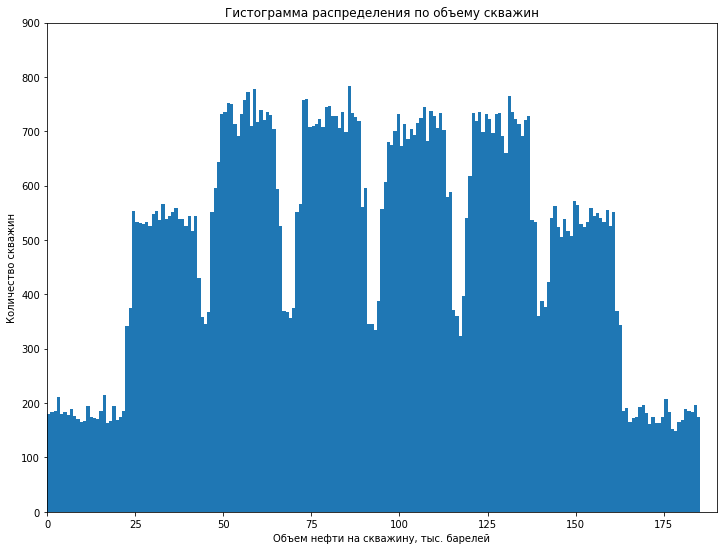

In [665]:
plot_product(geo_data_0['product'], 200, 190, 900)

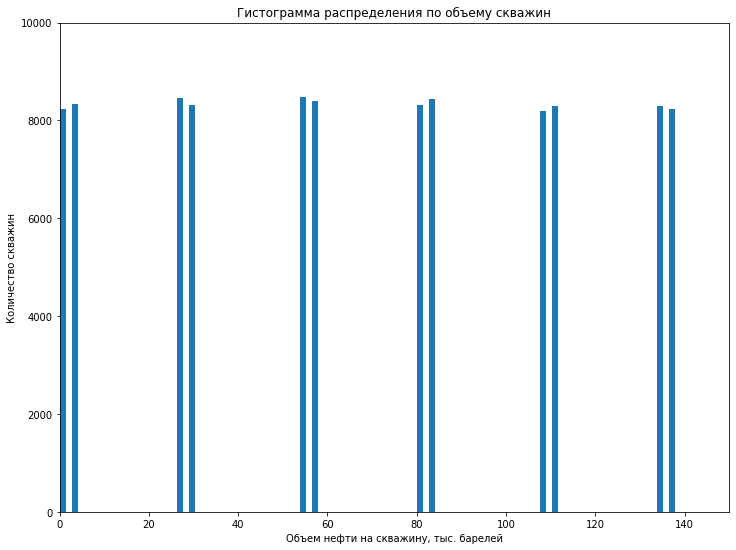

In [666]:
plot_product(geo_data_1['product'], 100, 150, 10000)

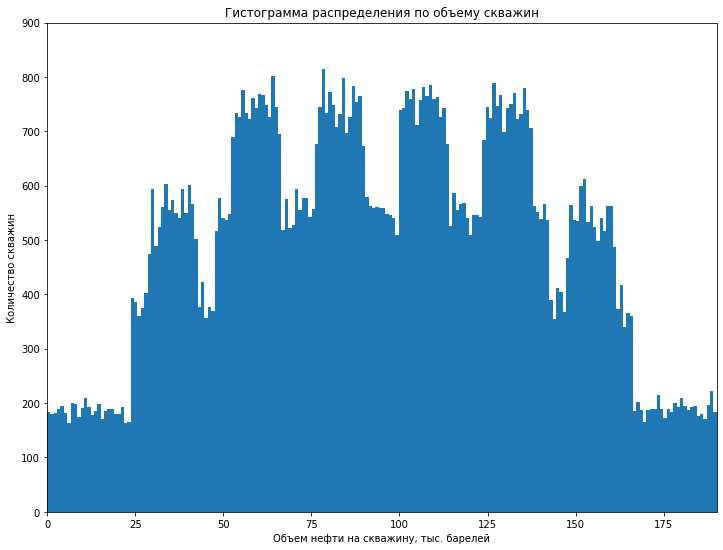

In [667]:
plot_product(geo_data_2['product'], 200, 190, 900)

Признаки: f0,f1,f2  
Целевой признак: product


## Обучение и проверка модели

### Разбивка данныx на обучающую и валидационную выборки.

In [668]:
def test_split(geo_data, target):
    features = geo_data.drop([target] , axis=1)
    target = geo_data[target]

    features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=12345)
    
    return features_train, features_valid, target_train, target_valid

In [669]:
features_train_0, features_valid_0, target_train_0, target_valid_0 = test_split(geo_data_0, 'product')
display(features_train_0.shape)
display(features_valid_0.shape)

(75000, 3)

(25000, 3)

In [670]:
features_train_1, features_valid_1, target_train_1, target_valid_1 = test_split(geo_data_1, 'product')
display(features_train_1.shape)
display(features_valid_1.shape)

(75000, 3)

(25000, 3)

In [671]:
features_train_2, features_valid_2, target_train_2, target_valid_2 = test_split(geo_data_2, 'product')
display(features_train_2.shape)
display(features_valid_2.shape)

(75000, 3)

(25000, 3)

### Обучение модели

In [672]:
model = LinearRegression()

model.fit(features_train_0, target_train_0)
predicted_target_0 = model.predict(features_valid_0)
print('RMSE:', mean_squared_error(target_valid_0, predicted_target_0)**0.5)

RMSE: 37.5794217150813


In [673]:
model = LinearRegression()

model.fit(features_train_1, target_train_1)
predicted_target_1 = model.predict(features_valid_1)
print('RMSE:', mean_squared_error(target_valid_1, predicted_target_1)**0.5)

RMSE: 0.893099286775617


In [674]:
model = LinearRegression()

model.fit(features_train_2, target_train_2)
predicted_target_2 = model.predict(features_valid_2)
print('RMSE:', mean_squared_error(target_valid_2, predicted_target_2)**0.5)

RMSE: 40.02970873393434


### Предсказания и правильные ответы на валидационной выборке. Средний запас предсказанного сырья и RMSE модели.

In [675]:
model = LinearRegression()

def geo_predict(df, target_name):
    features = df.drop([target_name] , axis=1)
    target = df[target_name]
    
    features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=12345)
    
    model.fit(features_train, target_train)
    predicted_target = model.predict(features_valid)
    data = {'real_product' : target_valid,
            'predicted_product' : predicted_target         
    }
    data_frame = pd.DataFrame(data, columns = ['real_product', 'predicted_product'])
    rmse = mean_squared_error(target_valid, predicted_target)**0.5
    mean = data_frame['predicted_product'].mean()
    oil_sum = data_frame['predicted_product'].sum()
    return data_frame, rmse, mean, oil_sum

In [676]:
geo_data_0_predicted, geo_data_0_rmse, geo_data_0_predicted_mean, geo_data_0_predicted_sum = geo_predict(geo_data_0, 'product')
print('RMSE:', geo_data_0_rmse)
print('Средний запас предсказанного  сырья:', geo_data_0_predicted_mean)
print('Суммарный предсказанный запас регионе 0:', geo_data_0_predicted_sum)
print('Суммарный реальный запас в регионе 0:', geo_data_0_predicted['real_product'].sum())

RMSE: 37.5794217150813
Средний запас предсказанного  сырья: 92.59256778438035
Суммарный предсказанный запас регионе 0: 2314814.194609509
Суммарный реальный запас в регионе 0: 2301964.918520732


In [677]:
geo_data_1_predicted, geo_data_1_rmse, geo_data_1_predicted_mean, geo_data_1_predicted_sum = geo_predict(geo_data_1, 'product')
print('RMSE:', geo_data_1_rmse)
print('Средний запас предсказанного  сырья:', geo_data_1_predicted_mean)
print('Суммарный предсказанный запас в регионе 1:', geo_data_1_predicted_sum)
print('Суммарный реальный запас в регионе 1:', geo_data_1_predicted['real_product'].sum())

RMSE: 0.893099286775617
Средний запас предсказанного  сырья: 68.728546895446
Суммарный предсказанный запас в регионе 1: 1718213.67238615
Суммарный реальный запас в регионе 1: 1718078.4006089992


In [678]:
geo_data_2_predicted, geo_data_2_rmse, geo_data_2_predicted_mean, geo_data_2_predicted_sum = geo_predict(geo_data_2, 'product')
print('RMSE:', geo_data_2_rmse)
print('Средний запас предсказанного  сырья:', geo_data_2_predicted_mean)
print('Суммарный предсказанный запас в регионе 2:', geo_data_2_predicted_sum)
print('Суммарный реальный запас в регионе 2:', geo_data_2_predicted['real_product'].sum())

RMSE: 40.02970873393434
Средний запас предсказанного  сырья: 94.96504596800489
Суммарный предсказанный запас в регионе 2: 2374126.1492001223
Суммарный реальный запас в регионе 2: 2372105.8202213594


Лучше всего модель предсказала запасы в регионе под номером 1 (RMSE - 0.89). Но возможно модель переобучилась из-за отсутствующих данных в этом датасете (0,08% нулевых значений). Думаю что из-за утери данных мы не можем назвать это местоположение самым прибыльным.

## Подготовка к расчёту прибыли

### Ключевые значения для расчётов 

In [688]:
selected_points = 500 #кол-во точек для исследования
budget = 1e+07 #бюджет
price_per_barrel = 450 #цена за один баррель
best_points = 200 #нужно выбрать лучших точек для разработки

### Достаточный объём сырья для безубыточной разработки новой скважины. Средний запас в каждом регионе.

In [689]:
#безубыточная разработка сырья на 200 месторождениях
average_profit_per_point = budget / best_points
print('Средняя прибыль на точку:', average_profit_per_point)

average_barrels_per_point = average_profit_per_point  / price_per_barrel
print('Средний объем нефти на точку:',average_barrels_per_point)

average_barrels = budget / price_per_barrel
print('Средний объем нефти на регион:',average_barrels)

Средняя прибыль на точку: 50000.0
Средний объем нефти на точку: 111.11111111111111
Средний объем нефти на регион: 22222.222222222223


In [690]:
print('Средний запас на скважину в регионе 0:', geo_data_0['product'].mean())
print('Средний запас на скважину в регионе 1:', geo_data_1['product'].mean())
print('Средний запас на скважину в регионе 2:', geo_data_2['product'].mean())

Средний запас на скважину в регионе 0: 92.50000000000001
Средний запас на скважину в регионе 1: 68.82500000000002
Средний запас на скважину в регионе 2: 95.00000000000004


Запас сырья в скважинах меньше, чем точка безубыточности.

## Расчёт прибыли и рисков 

In [691]:
#ф-я для рассчета прибыли 
def profit_calculation(target, probabilities, count):
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:count]
    return price_per_barrel * selected.sum() - budget

In [692]:
state = np.random.RandomState(1234567)
def bootstrap(target, probs):
    values=[]
    lost = 0
    for i in range(1000):
        target_sample = target.sample(replace=False, random_state=state, n=selected_points)
        probs_sample = probs[target_sample.index]
        profit = profit_calculation(target, probs_sample, best_points)
        if profit < 0:
            lost +=1
        values.append(profit)
    
    values = pd.Series(values)
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    average = values.mean()
    risk = lost / 1000
    return average, lower, upper, risk

In [693]:
average_0, lower_0, upper_0, risk_0 = bootstrap(geo_data_0_predicted['real_product'], 
                                                     geo_data_0_predicted['predicted_product'])
print('Данные по региону 0:')
print('Средняя прибыль по региону = {:.2f} тыс.руб.'.format(average_0))
print('95% доверительный интервал от {:.2f} до {:.2f} тыс.руб.'.format(lower_0, upper_0))
print('Процент риска {:.2%}'.format(risk_0))

Данные по региону 0:
Средняя прибыль по региону = 386164.63 тыс.руб.
95% доверительный интервал от -155651.27 до 882466.63 тыс.руб.
Процент риска 8.20%


In [694]:
average_1, lower_1, upper_1, risk_1 = bootstrap(geo_data_1_predicted['real_product'], 
                                                     geo_data_1_predicted['predicted_product'])
print('Данные по региону 1:')
print('Средняя прибыль по региону = {:.2f} тыс.руб.'.format(average_1))
print('95% доверительный интервал от {:.2f} до {:.2f} тыс.руб.'.format(lower_1, upper_1))
print('Процент риска {:.2%}'.format(risk_1))

Данные по региону 1:
Средняя прибыль по региону = 444770.64 тыс.руб.
95% доверительный интервал от 49448.22 до 867298.27 тыс.руб.
Процент риска 1.30%


In [695]:
average_2, lower_2, upper_2, risk_2 = bootstrap(geo_data_2_predicted['real_product'], 
                                                     geo_data_2_predicted['predicted_product'])
print('Данные по региону 2:')
print('Средняя прибыль по региону = {:.2f} тыс.руб.'.format(average_2))
print('95% доверительный интервал от {:.2f} до {:.2f} тыс.руб.'.format(lower_2, upper_2))
print('Процент риска {:.2%}'.format(risk_2))

Данные по региону 2:
Средняя прибыль по региону = 403643.00 тыс.руб.
95% доверительный интервал от -148706.81 до 899324.59 тыс.руб.
Процент риска 6.20%


# Вывод

Применена техника Bootstrap с 1000 выборок, чтобы найти распределение прибыли. Найдена средняя прибыль, 95%-й доверительный интервал и риск убытков.  
Мы вынуждены отсеить регион0 и регион2, так как у них высокий процент риска.   
Лучшие показатели у региона под номером 1. Минимальный процентр риска 1.3% и нижняя граница доверительного интервала в плюсе.